In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
import malaya_speech
import malaya_speech.config
from malaya_speech.train.model import revsic_glowtts as glowtts
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt

In [4]:
import pickle

with open('dataset-mel.pkl', 'rb') as fopen:
    data, d = pickle.load(fopen)
    
with open('dataset-mel-wav.pkl', 'rb') as fopen:
    wav = pickle.load(fopen)
    
data.keys()

dict_keys(['mel', 'text_ids', 'len_mel', 'len_text_ids', 'stop_token_target', 'f0', 'len_f0', 'energy', 'len_energy', 'g'])

In [5]:
i = tf.placeholder(tf.int32, [None, None])
i_lengths = tf.placeholder(tf.int32, [None])
mel_outputs = tf.placeholder(tf.float32, [None, None, 80])
mel_lengths = tf.placeholder(tf.int32, [None])

In [6]:
config = glowtts.Config(mel = 80, vocabs = 66)

In [7]:
model = glowtts.Model(config)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
loss, losses, attn = model.compute_loss(text = i, textlen = i_lengths, mel = mel_outputs, mellen = mel_lengths)
loss, losses, attn

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(<tf.Tensor 'add_4:0' shape=() dtype=float32>,
 {'nll': <tf.Tensor 'Mean:0' shape=() dtype=float32>,
  'durloss': <tf.Tensor 'Mean_1:0' shape=() dtype=float32>,
  'mel_': <tf.Tensor 'Reshape_2:0' shape=(?, ?, ?) dtype=float32>},
 <tf.Tensor 'StopGradient:0' shape=(?, ?, ?) dtype=float32>)

In [9]:
mel, mellen, attn_out = model(inputs = i, lengths = i_lengths)
mel, mellen, attn_out

(<tf.Tensor 'model/Reshape_50:0' shape=(?, ?, ?) dtype=float32>,
 <tf.Tensor 'model/mul_90:0' shape=(?,) dtype=int32>,
 <tf.Tensor 'model/transpose:0' shape=(?, ?, ?) dtype=float32>)

In [10]:
parameters = {
    'optimizer_params': {'beta1': 0.9, 'beta2': 0.98, 'epsilon': 1e-9},
    'lr_policy_params': {
        'warmup_steps': 40000,
    },
}

def noam_schedule(step, learning_rate, channels, warmup_steps=4000):
    return learning_rate * channels ** -0.5 * \
            tf.minimum(step ** -0.5, step * warmup_steps ** -1.5)

def learning_rate_scheduler(global_step):
    return transformer_schedule(
        tf.cast(global_step, tf.float32),
        config.channels,
        **parameters['lr_policy_params'],
    )

In [11]:
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.9, 
                                   beta2 = 0.98, epsilon = 1e-9).minimize(loss)

In [12]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [13]:
%%time

o = sess.run(mel, feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                               mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408]})

CPU times: user 2.37 s, sys: 170 ms, total: 2.54 s
Wall time: 1.87 s


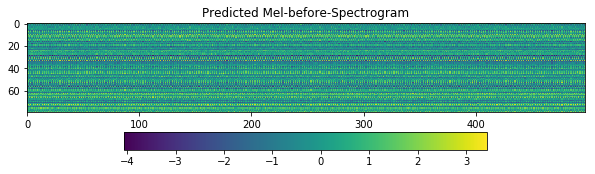

In [14]:
mel_outputs_ = np.reshape(o[0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [24]:
%%time

o = sess.run([loss, losses, attn], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                               mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408]})

CPU times: user 788 ms, sys: 167 ms, total: 955 ms
Wall time: 197 ms


In [28]:
o[2].shape

(2, 205, 72)

In [16]:
for k in range(100):
    o = sess.run([loss, losses, optimizer], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                               mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408]})
    print(k, o)

0 [1.5948588, {'nll': 1.0196465, 'durloss': 0.57521224, 'mel_': array([[[ 8.293662  ,  2.9109554 ,  9.567988  , ...,  1.3944303 ,
          4.772536  ,  1.5890015 ],
        [-2.4947019 ,  0.78371704, -1.7493379 , ...,  0.47372577,
         -1.3538848 ,  0.3383085 ],
        [ 7.8821654 ,  2.6676483 ,  8.425519  , ...,  1.4188002 ,
          4.3139977 ,  1.4589493 ],
        ...,
        [-2.118722  ,  0.9545761 , -2.118722  , ...,  0.9545761 ,
         -2.118722  ,  0.9545761 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 8.293662  ,  2.9109554 ,  9.567988  , ...,  1.3944303 ,
          4.772536  ,  1.5890015 ],
        [-2.4947019 ,  0.78371704, -1.7493379 , ...,  0.47372577,
         -1.3538848 ,  0.3383085 ],
        [ 7.8821654 ,  2.6676483 ,  8.425519  , ...,  1.4188002 ,
          4.3139977 ,  1.4589493 ],
   

7 [0.9309444, {'nll': 0.5127803, 'durloss': 0.41816407, 'mel_': array([[[ 5.9198637 ,  1.4780368 ,  6.880985  , ...,  0.5906205 ,
          3.28917   ,  0.68392324],
        [-2.1674697 ,  0.6482856 , -1.4939288 , ...,  0.43417254,
         -1.1742169 ,  0.13743056],
        [ 5.618013  ,  1.3236243 ,  6.021222  , ...,  0.65793   ,
          2.9579196 ,  0.6818724 ],
        ...,
        [-1.8152589 ,  0.9153911 , -1.7040846 , ...,  1.0084864 ,
         -1.8189449 ,  0.7502568 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.        ]],

       [[ 5.9198637 ,  1.4780368 ,  6.880985  , ...,  0.5906205 ,
          3.28917   ,  0.68392324],
        [-2.1674697 ,  0.6482856 , -1.4939288 , ...,  0.43417254,
         -1.1742169 ,  0.13743056],
        [ 5.618013  ,  1.3236243 ,  6.021222  , ...,  0.65793   ,
          2.9579196 ,  0.6818724 ],
   

13 [0.55858034, {'nll': 0.21679842, 'durloss': 0.3417819, 'mel_': array([[[ 3.035535  ,  0.02659369,  3.5153363 , ..., -0.19087994,
          1.5150826 , -0.04876667],
        [-1.7490175 ,  0.4110068 , -1.3284113 , ...,  0.15637636,
         -0.993714  , -0.07678865],
        [ 2.9112124 ,  0.02273661,  3.0820909 , ..., -0.05676299,
          1.3399202 ,  0.05303133],
        ...,
        [-1.3731624 ,  0.6765521 , -1.4462281 , ...,  0.6230458 ,
         -1.4645123 ,  0.49529868],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.        ]],

       [[ 3.035535  ,  0.02659369,  3.5153363 , ..., -0.19087994,
          1.5150826 , -0.04876667],
        [-1.7490175 ,  0.4110068 , -1.3284113 , ...,  0.15637636,
         -0.993714  , -0.07678865],
        [ 2.9112124 ,  0.02273661,  3.0820909 , ..., -0.05676299,
          1.3399202 ,  0.05303133],
 

20 [0.23493077, {'nll': -0.06585966, 'durloss': 0.30079043, 'mel_': array([[[ 1.3681276 , -0.28658718,  1.6673856 , ..., -0.26352403,
          0.7908133 ,  0.09766233],
        [-1.6606987 ,  0.48542935, -0.8489199 , ...,  0.32476524,
         -0.70479125, -0.132669  ],
        [ 1.3078151 , -0.16910231,  1.3851985 , ..., -0.00990295,
          0.70859706,  0.23617351],
        ...,
        [-1.2276602 ,  1.4275914 , -1.2462767 , ...,  1.5311    ,
         -0.87318313,  1.371738  ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.        ]],

       [[ 1.3681276 , -0.28658718,  1.6673856 , ..., -0.26352403,
          0.7908133 ,  0.09766233],
        [-1.6606987 ,  0.48542935, -0.8489199 , ...,  0.32476524,
         -0.70479125, -0.132669  ],
        [ 1.3078151 , -0.16910231,  1.3851985 , ..., -0.00990295,
          0.70859706,  0.23617351],

27 [0.04216951, {'nll': -0.25688344, 'durloss': 0.29905295, 'mel_': array([[[ 1.0193403 ,  0.25879136,  1.6342692 , ..., -0.26729396,
          0.7734946 ,  0.4743902 ],
        [-1.7369126 , -0.86332124, -0.00263095, ...,  0.1107296 ,
         -0.42272848, -1.0530031 ],
        [ 1.0427363 ,  0.5034465 ,  1.4550745 , ...,  0.1569922 ,
          0.8661021 ,  0.6138966 ],
        ...,
        [-0.43640822,  0.7694906 , -0.2196036 , ...,  1.3627807 ,
          0.14867608,  0.7882669 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.        ]],

       [[ 1.0193403 ,  0.25879136,  1.6342692 , ..., -0.26729396,
          0.7734946 ,  0.4743902 ],
        [-1.7369126 , -0.86332124, -0.00263095, ...,  0.1107296 ,
         -0.42272848, -1.0530031 ],
        [ 1.0427363 ,  0.5034465 ,  1.4550745 , ...,  0.1569922 ,
          0.8661021 ,  0.6138966 ],

34 [-0.07248455, {'nll': -0.39946455, 'durloss': 0.32698, 'mel_': array([[[ 1.1798078 ,  0.4164647 ,  1.6263807 , ..., -0.04786687,
          0.35107723, -0.19952455],
        [-1.4851111 , -1.3055011 ,  0.11992708, ..., -0.44356775,
         -0.37716225, -1.0078083 ],
        [ 1.1773778 ,  0.8434363 ,  1.418572  , ...,  0.53398937,
          0.5169101 ,  0.07569929],
        ...,
        [-0.48793072,  0.16425984, -0.21680883, ...,  0.30922556,
         -0.17173542,  0.37314746],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.        ]],

       [[ 1.1798078 ,  0.4164647 ,  1.6263807 , ..., -0.04786687,
          0.35107723, -0.19952455],
        [-1.4851111 , -1.3055011 ,  0.11992708, ..., -0.44356775,
         -0.37716225, -1.0078083 ],
        [ 1.1773778 ,  0.8434363 ,  1.418572  , ...,  0.53398937,
          0.5169101 ,  0.07569929],
 

41 [-0.20460808, {'nll': -0.5046232, 'durloss': 0.3000151, 'mel_': array([[[ 1.2759326 ,  0.35063323,  1.6139417 , ..., -0.81103003,
          0.19249547, -0.1733476 ],
        [-1.5707023 , -1.4738373 ,  0.25422075, ...,  0.0599734 ,
         -0.7636428 , -0.9951833 ],
        [ 1.1334674 ,  0.82287323,  1.0688455 , ..., -0.24157012,
          0.30391222,  0.23886648],
        ...,
        [-0.81397206, -0.10692522, -0.4267848 , ...,  1.0222179 ,
         -0.63030124,  0.29896086],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.        ]],

       [[ 1.2759326 ,  0.35063323,  1.6139417 , ..., -0.81103003,
          0.19249547, -0.1733476 ],
        [-1.5707023 , -1.4738373 ,  0.25422075, ...,  0.0599734 ,
         -0.7636428 , -0.9951833 ],
        [ 1.1334674 ,  0.82287323,  1.0688455 , ..., -0.24157012,
          0.30391222,  0.23886648],


47 [-0.28875202, {'nll': -0.5802094, 'durloss': 0.29145736, 'mel_': array([[[ 1.0977623 ,  0.14006075,  1.8648034 , ..., -0.5799976 ,
          0.342602  ,  0.08547541],
        [-1.4709742 , -0.9481484 ,  0.6684168 , ...,  0.33138588,
         -0.5824626 , -0.9918746 ],
        [ 1.1978273 ,  0.742032  ,  1.2617134 , ..., -0.20460117,
          0.66001153,  0.48071903],
        ...,
        [-0.76180106, -0.17622955, -0.3752372 , ...,  0.9865327 ,
         -0.16616651,  0.3519612 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.        ]],

       [[ 1.0977623 ,  0.14006075,  1.8648034 , ..., -0.5799976 ,
          0.342602  ,  0.08547541],
        [-1.4709742 , -0.9481484 ,  0.6684168 , ...,  0.33138588,
         -0.5824626 , -0.9918746 ],
        [ 1.1978273 ,  0.742032  ,  1.2617134 , ..., -0.20460117,
          0.66001153,  0.48071903],

54 [-0.43075752, {'nll': -0.6694902, 'durloss': 0.2387327, 'mel_': array([[[ 0.9608099 ,  0.11463009,  2.1347852 , ..., -0.41095868,
          0.42591697, -0.00364494],
        [-1.3095462 , -0.70768696,  1.2022213 , ...,  0.14346254,
         -0.56573904, -0.902241  ],
        [ 1.2378213 ,  0.7726284 ,  1.2076192 , ...,  0.09227926,
          0.8620472 ,  0.4209997 ],
        ...,
        [-0.28022984, -0.6560243 , -0.4111344 , ..., -0.34806022,
         -0.47373295,  0.6117761 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.        ]],

       [[ 0.9608099 ,  0.11463009,  2.1347852 , ..., -0.41095868,
          0.42591697, -0.00364494],
        [-1.3095462 , -0.70768696,  1.2022213 , ...,  0.14346254,
         -0.56573904, -0.902241  ],
        [ 1.2378213 ,  0.7726284 ,  1.2076192 , ...,  0.09227926,
          0.8620472 ,  0.4209997 ],


61 [-0.46754158, {'nll': -0.74777853, 'durloss': 0.28023696, 'mel_': array([[[ 0.9534972 ,  0.34054112,  2.238272  , ..., -0.44407988,
          0.49344277,  0.6780084 ],
        [-1.4981507 , -0.726336  ,  1.424654  , ...,  0.03508181,
         -0.7443771 , -0.9898881 ],
        [ 1.2600834 ,  1.0258387 ,  1.158094  , ..., -0.0467599 ,
          0.8764299 ,  1.0025058 ],
        ...,
        [ 0.02362882, -0.6773983 , -0.1480076 , ...,  0.30395335,
         -0.70711154,  0.6778483 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.        ]],

       [[ 0.9534972 ,  0.34054112,  2.238272  , ..., -0.44407988,
          0.49344277,  0.6780084 ],
        [-1.4981507 , -0.726336  ,  1.424654  , ...,  0.03508181,
         -0.7443771 , -0.9898881 ],
        [ 1.2600834 ,  1.0258387 ,  1.158094  , ..., -0.0467599 ,
          0.8764299 ,  1.0025058 ]

68 [-0.5307367, {'nll': -0.80153286, 'durloss': 0.27079618, 'mel_': array([[[ 9.4330919e-01,  4.5634905e-01,  1.9635228e+00, ...,
         -1.5886225e-01,  3.3789599e-01,  4.0484777e-01],
        [-1.7579446e+00, -3.6009464e-01,  8.3129764e-01, ...,
         -1.3244782e-02, -7.7381742e-01, -7.0933682e-01],
        [ 1.2932497e+00,  1.2721374e+00,  1.1261575e+00, ...,
          2.6918846e-01,  6.4957887e-01,  7.3246431e-01],
        ...,
        [-8.3133042e-02, -5.6759757e-01, -6.3685447e-01, ...,
         -1.2794808e-03, -1.2341412e+00,  1.6958019e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00, -0.0000000e+00]],

       [[ 9.4330919e-01,  4.5634905e-01,  1.9635228e+00, ...,
         -1.5886225e-01,  3.3789599e-01,  4.0484777e-01],
        [-1.7579446e+00, -3.6009464e-01,  8.3129764e-01, ...,
         -1.324

74 [-0.60699487, {'nll': -0.85572183, 'durloss': 0.24872696, 'mel_': array([[[ 1.0822724 ,  0.4511157 ,  1.9310076 , ..., -0.62654114,
          0.52505255,  0.65078866],
        [-1.6559464 , -0.6199533 ,  1.2398564 , ...,  0.24244717,
         -0.4385647 , -1.2218345 ],
        [ 1.3013667 ,  1.1588151 ,  1.1875827 , ..., -0.27459657,
          0.7048352 ,  0.8763798 ],
        ...,
        [ 0.96882045, -0.99480015,  0.07197931, ...,  0.8866942 ,
         -0.7157725 ,  0.4647123 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.        ]],

       [[ 1.0822724 ,  0.4511157 ,  1.9310076 , ..., -0.62654114,
          0.52505255,  0.65078866],
        [-1.6559464 , -0.6199533 ,  1.2398564 , ...,  0.24244717,
         -0.4385647 , -1.2218345 ],
        [ 1.3013667 ,  1.1588151 ,  1.1875827 , ..., -0.27459657,
          0.7048352 ,  0.8763798 ]

81 [-0.6468208, {'nll': -0.9006268, 'durloss': 0.25380597, 'mel_': array([[[ 8.7026584e-01,  2.1814784e-01,  1.6660811e+00, ...,
         -3.4586483e-01,  4.1376573e-01,  6.3138771e-01],
        [-2.2407999e+00, -4.6412352e-01,  7.5469071e-01, ...,
          5.3752322e-02, -7.0356876e-01, -1.1388015e+00],
        [ 1.0554100e+00,  9.4296110e-01,  1.0433903e+00, ...,
          7.6306999e-02,  4.8773417e-01,  9.1416657e-01],
        ...,
        [-3.6496565e-01, -1.2112266e+00, -7.6306927e-01, ...,
          3.2024086e-04, -1.7922121e+00,  1.2378273e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00, -0.0000000e+00]],

       [[ 8.7026584e-01,  2.1814784e-01,  1.6660811e+00, ...,
         -3.4586483e-01,  4.1376573e-01,  6.3138771e-01],
        [-2.2407999e+00, -4.6412352e-01,  7.5469071e-01, ...,
          5.3752

87 [-0.67299974, {'nll': -0.93803084, 'durloss': 0.26503107, 'mel_': array([[[ 0.9768298 ,  0.05852044,  1.6883476 , ..., -0.540823  ,
          0.5458704 ,  0.14736508],
        [-2.1409228 , -0.4637137 ,  1.2840345 , ..., -0.0956438 ,
         -0.3783837 , -1.3940015 ],
        [ 1.1313398 ,  0.7360161 ,  1.1321497 , ..., -0.04972315,
          0.68649507,  0.62077993],
        ...,
        [-0.00398237, -0.5902954 , -0.22466046, ...,  0.3929413 ,
         -1.2120345 ,  0.51670146],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.        ]],

       [[ 0.9768298 ,  0.05852044,  1.6883476 , ..., -0.540823  ,
          0.5458704 ,  0.14736508],
        [-2.1409228 , -0.4637137 ,  1.2840345 , ..., -0.0956438 ,
         -0.3783837 , -1.3940015 ],
        [ 1.1313398 ,  0.7360161 ,  1.1321497 , ..., -0.04972315,
          0.68649507,  0.62077993]

94 [-0.75580484, {'nll': -0.99511313, 'durloss': 0.2393083, 'mel_': array([[[ 0.9682956 ,  0.22736612,  1.7362831 , ..., -0.31601945,
          0.68985605,  0.5645352 ],
        [-2.2728307 , -1.0399675 ,  1.313636  , ..., -0.07690972,
         -0.3445687 , -1.6508552 ],
        [ 1.0722446 ,  0.8506059 ,  1.0903744 , ...,  0.10291779,
          0.5673095 ,  1.0412095 ],
        ...,
        [-0.47263318, -1.5333345 ,  0.19391385, ...,  0.93277645,
         -1.1090465 ,  0.7386486 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.        ]],

       [[ 0.9682956 ,  0.22736612,  1.7362831 , ..., -0.31601945,
          0.68985605,  0.5645352 ],
        [-2.2728307 , -1.0399675 ,  1.313636  , ..., -0.07690972,
         -0.3445687 , -1.6508552 ],
        [ 1.0722446 ,  0.8506059 ,  1.0903744 , ...,  0.10291779,
          0.5673095 ,  1.0412095 ],

In [17]:
%%time

o = sess.run([loss, losses, attn], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                               mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408]})

CPU times: user 855 ms, sys: 158 ms, total: 1.01 s
Wall time: 192 ms


In [18]:
o = sess.run([mel, mellen, attn_out], feed_dict = {i: [data['text_ids'][0],data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0], data['len_text_ids'][0,0]],
                                        mel_outputs: [data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]],
                                               mel_lengths: [408, 408]})

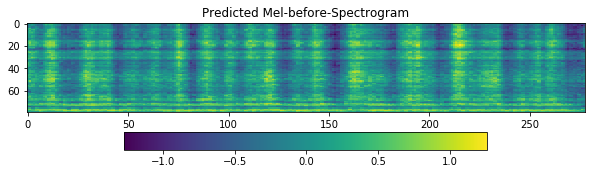

In [19]:
mel_outputs_ = np.reshape(o[0][0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

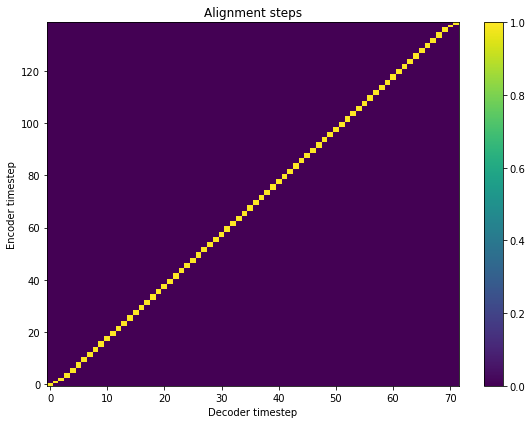

In [20]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o[-1][0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [21]:
saver = tf.train.Saver()
saver.save(sess, 'test/model.ckpt')

'test/model.ckpt'